# Decision trees and Support Vector Machines
## Scikit-Learn and Snap ML on unbalanced classification

Created on JupyterLab

*See also the Matlab code about Support Vectors Machines*

Here, the Scikit-Learn Python interface and the Python API offered by the Snap Machine Learning (Snap ML) library. Snap ML is a high-performance IBM library for ML modeling. It provides highly-efficient CPU/GPU implementations of linear models and tree-based models. Snap ML not only accelerates ML algorithms through system awareness, but it also offers novel ML algorithms with best-in-class accuracy. For more information, please visit [snapml](https://ibm.biz/BdPfxy) information page.

Dataset from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download&select=creditcard.csv

Libraries

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

Install snapml

In [2]:
#!pip install snapml

In [3]:
# read the input data
raw_data = pd.read_csv('creditcard.csv')
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

# display the first rows in the dataset
raw_data.head()

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Remove columns with NaN values

In [4]:
raw_data = raw_data.dropna()
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


In practice, a financial institution may have access to a much larger dataset of transactions. To simulate such a case, we will inflate the original one 10 times.

In [5]:
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")

# display first rows in the new dataset
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


Each row in the dataset represents a credit card transaction. As shown above, each row has 31 variables. One variable (the last variable in the table above) is called Class and represents the target variable.

Note: For confidentiality reasons, the original names of most features are anonymized V1, V2 .. V28. The values of these features are the result of a Principal Component Analysis transformation and are numerical. The feature 'Class' is the target variable and it takes two values: 1 in case of fraud and 0 otherwise.

In [6]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()
labels

array([0., 1.])

In [7]:
# get the count of each class
sizes = big_raw_data.Class.value_counts().values
sizes

array([2843150,    4920], dtype=int64)

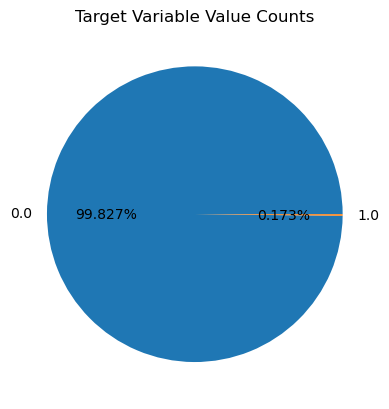

In [8]:
# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As shown above, the Class variable has two values: 0 (the credit card transaction is legitimate) and 1 (the credit card transaction is fraudulent). Thus, you need to model a **binary classification** problem. Moreover, the dataset is **highly unbalanced**, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at train time is to **bias the model to pay more attention to the samples in the minority class**. The models under the current study will be configured to take into account the **class weights** of the samples at **train/fit time**.

Data preprocessing

In [9]:
# data preprocessing such as scaling/normalization is typically useful for 
# linear models to accelerate the training convergence

# standardize features by removing the mean and scaling to unit variance
# (for this analysis, we exclude the Time variable from the dataset)
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

In [10]:
big_raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964,0.0
1,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964,0.0
2,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964,0.0
3,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964,0.0
4,0.0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.39217,0.330892,-0.063781,0.244964,0.0


In [11]:
# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]
X.shape

(2848070, 29)

In [12]:
# y: labels vector
y = data_matrix[:, 30]
y

array([0., 0., 0., ..., 0., 0., 0.])

The L1 norm that is calculated as the sum of the absolute values of the vector (e.g., |a1| + |a2| + |a3|).

The L2 norm that is calculated as the square root of the sum of the squared vector values (e.g., sqrt(a1^2 + a2^2 + a3^2))

The max norm that is calculated as the maximum vector values (e.g., max(|a1|, |a2|, |a3|)).

In [13]:
# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


Select random rows to set apart 70% of the data for training and 30% for testing

Stratify is used to keep the same proportions between classes as the initial dataset. 

Random state is used to enable reproducible results.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


**Build a Decision Tree Classifier model with Scikit-Learn**

Compute the sample weights to be used as input to the train routine so that it takes into account the class imbalance present in this dataset

The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data: 
n_samples / (n_classes * np.bincount(y)).

In [15]:
w_train = compute_sample_weight('balanced', y_train)

In [16]:
# import the Decision Tree Classifier Model from scikit-learn
from sklearn.tree import DecisionTreeClassifier

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

# train a Decision Tree Classifier using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  20.00949


**Build a Decision Tree Classifier model with Snap ML**

In [17]:
# if not already computed, 
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
# w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from Snap ML
from snapml import DecisionTreeClassifier

Snap ML offers multi-threaded CPU/GPU training of decision trees, unlike scikit-learn to use the GPU, set the use_gpu parameter to True 

*snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, use_gpu=True)*

To set the number of CPU threads used at training time, set the n_jobs parameter
For reproducible output across multiple function calls, set random_state to a given integer value

In [18]:
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)

In [19]:
# train a Decision Tree Classifier model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  2.02182


**Evaluate the Scikit-Learn and Snap ML Decision Tree Classifier Models**

Area Under the Receiver Operating Characteristic Curve (ROC-AUC) can be used to compare classifiers.

An ROC curve summarizes the performance of a binary classification model on the *positive class* (i.e., in imbalanced classification problems: the *minority class*). **The False Positive Rate (FalsePositiveRate = FalsePositives / (FalsePositives + TrueNegatives)) is plotted on the x axix and the True Positive Rate (TruePositiveRate = TruePositives / (TruePositives + False Negatives), = Recall) on the y axis.**

That is, the ROC represents the correct predictions of the positive class (y axis) as a function of errors on the negative class (x axis). Thus, the point in the top left of the plot represents a perfect performance (correct prediction of the positive class and no error on the negative class).

A threshold can be considered, that corresponds to the cut-off point in probability between the positive and negative classes, which would be set at 0.5. However, by variying the threshold values and assessing the true positive and false positives for each one of the thresholds, a curve can be created, that is the ROC curve.

The ROC curve of a classifier that has no discriminative power between positive and negative classes would be a perfect diagonal (True positive rate = 0 when false positive rate = 0 and true positive rate = 1 when false positive rate = 1).

**The area under the curve (AUC) gives a single score across all threshold values: this is the ROC AUC value.** It is in range [0 1] where 1 indicates a perfect classifier.

**Nevertheless, for imbalanced classification the ROC AUC may be unreliable to compare classifiers because the ROC curve may rapidly change for a small number of correct or incorrect predictions.** Therfore, ROC AUC may be incorrectly optimistic for skewed models. 

Alternatively, the **precision-recall curve (PRC) and its AUC** may be implemented.

The precision is defined by: **Precision = TruePositives / (TruePositives + FalsePositives)**

**A precision-recall curve plots the precision on the y axis and the recall on the x axis for several probability thresholds.**

The point in the top right of the plot represents a perfect performance (precision and recall to 1). 

The RPC curve of a classifier that has no discriminative power between positive and negative classes would be an horizontal curve with the precision (y) proportionnal to the number of positive samples. If the dataset is balanced between classes, it would be at y=0.5.  

The PR curve focuses on the minority class as both precision and recall are centered on positive samples. It is therefore adequate to assess the performance of imbalanced classification models. 

**In sum, the PR curve focuses on the minority class, whereas the ROC curve covers both positive and negative classes.**
Indeed, the False Positive Rate to compute the ROC uses true negatives whereas the Precision-Recall curve carefully avoids this rate.

In [20]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference and compute the probabilities of the test samples 
# to belong to the class of fraudulent transactions
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic 
# Curve (ROC-AUC) score from the predictions
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : 9.90x 
[Scikit-Learn] ROC-AUC score : 0.966


In [21]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# evaluate the Precision-Recall curve and AUC score from the predictions
precision_sklearn, recall_sklearn, thresholds_sklearn = precision_recall_curve(y_test, sklearn_pred, pos_label=1)
#precision_sklearn,recall_sklearn,thresholds_sklearn

In [22]:
sklearn_prc_auc = auc(recall_sklearn, precision_sklearn)

print('[Scikit-Learn] RPC-AUC score : {0:.3f}'.format(sklearn_prc_auc))

[Scikit-Learn] RPC-AUC score : 0.500


In [23]:
# run inference and compute the probabilities of the test samples
# to belong to the class of fraudulent transactions
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic
# Curve (ROC-AUC) score from the prediction scores
snapml_roc_auc = roc_auc_score(y_test, snapml_pred)   
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

# evaluate the Precision-Recall curve and AUC score from the predictions
precision_snapml, recall_snapml, thresholds_snapml = precision_recall_curve(y_test, snapml_pred, pos_label=1)
#precision_snapml,recall_snapml,thresholds_snapml

[Snap ML] ROC-AUC score : 0.966


In [24]:
snapml_prc_auc = auc(recall_snapml, precision_snapml)

print('[Snap ML] RPC-AUC score : {0:.3f}'.format(snapml_prc_auc))

[Snap ML] RPC-AUC score : 0.499


Plots

In [25]:
from sklearn.dummy import DummyClassifier

A no skill classifier (that has no discriminative power between positive and negative classes) is evaluated alongside for reference.

In [26]:
# plot no skill and model roc curves
from sklearn.metrics import roc_curve
from matplotlib import pyplot
def plot_roc_curve(test_y, naive_probs, model_probs, model):
 # plot naive skill roc curve
 fpr, tpr, _ = roc_curve(test_y, naive_probs)
 pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
 # plot model roc curve
 fpr, tpr, _ = roc_curve(test_y, model_probs)
 pyplot.plot(fpr, tpr, marker='.', label=model)
 # axis labels
 pyplot.xlabel('False Positive Rate')
 pyplot.ylabel('True Positive Rate (recall)')
 # show the legend
 pyplot.legend()
 pyplot.title('ROC')
 # show the plot
 pyplot.show()

# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs, model):
 # calculate the no skill line as the proportion of the positive class
 no_skill = len(test_y[test_y==1]) / len(test_y)
 # plot the no skill precision-recall curve
 pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
 # plot model precision-recall curve
 precision, recall, _ = precision_recall_curve(y_test, model_probs, pos_label=1)
 pyplot.plot(recall, precision, marker='.', label=model)
 # axis labels
 pyplot.xlabel('Recall')
 pyplot.ylabel('Precision')
 # show the legend
 pyplot.legend()
 pyplot.title('PRC')
 # show the plot
 pyplot.show()

In [27]:
# no skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)
naive_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(y_test, naive_probs)
print('No Skill ROC AUC %.3f' % roc_auc)

# calculate the precision-recall auc
precision, recall, thresholds = precision_recall_curve(y_test, naive_probs, pos_label=1)
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score)

No Skill ROC AUC 0.500
No Skill PR AUC: 0.003


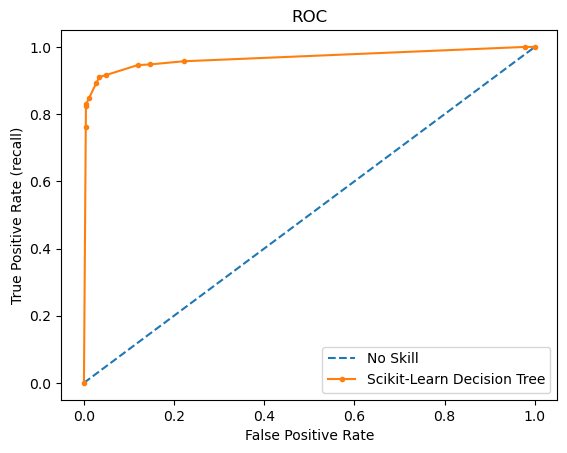

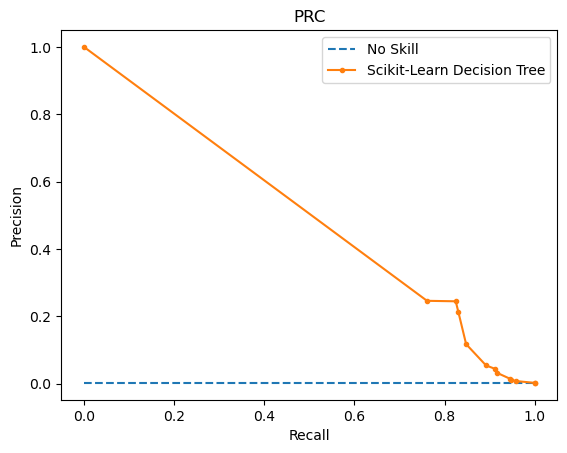

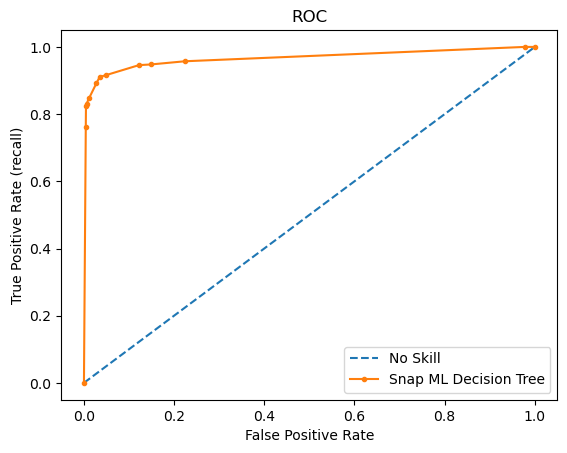

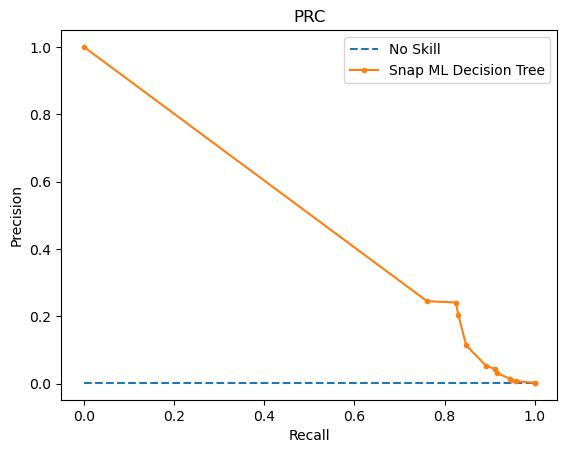

In [28]:
# plot roc curves
plot_roc_curve(y_test, naive_probs, sklearn_pred, 'Scikit-Learn Decision Tree')

# plot precision-recall curves
plot_pr_curve(y_test, sklearn_pred, 'Scikit-Learn Decision Tree')

# plot roc curves
plot_roc_curve(y_test, naive_probs, snapml_pred, 'Snap ML Decision Tree')

# plot precision-recall curves
plot_pr_curve(y_test, snapml_pred, 'Snap ML Decision Tree')

*We can observe that the model is skewed towards predicting the majority class. The scores highlight that the model that looked accurate according to the ROC curve is in fact less skillful when focusing only on the positive class (RP curve).*

**Build a Support Vector Machine model with Scikit-Learn**

In [29]:
# import the linear Support Vector Machine (SVM) model from Scikit-Learn
from sklearn.svm import LinearSVC

# instatiate a scikit-learn SVM model
# to indicate the class imbalance at fit time, set class_weight='balanced'
# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

# train a linear Support Vector Machine model using Scikit-Learn
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  48.52


**Build a Support Vector Machine model with Snap ML**

In [30]:
# import the Support Vector Machine model (SVM) from Snap ML
from snapml import SupportVectorMachine

# in contrast to scikit-learn's LinearSVC, Snap ML offers multi-threaded CPU/GPU training of SVMs
# to use the GPU, set the use_gpu parameter to True
# snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, use_gpu=True, fit_intercept=False)

# to set the number of threads used at training time, one needs to set the n_jobs parameter
snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)
# print(snapml_svm.get_params())

# train an SVM model using Snap ML
t0 = time.time()
model = snapml_svm.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.2f}".format(snapml_time))

[Snap ML] Training time (s):  5.99


**Evaluate the Scikit-Learn and Snap ML Support Vector Machine Models**

In [31]:
# compute the Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : {0:.2f}x '.format(training_speedup))

# run inference using the Scikit-Learn model
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)

# evaluate accuracy on test set
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn))

# run inference using the Snap ML model
# get the confidence scores for the test samples
snapml_pred = snapml_svm.decision_function(X_test)

# evaluate accuracy on test set
acc_snapml  = roc_auc_score(y_test, snapml_pred)
print("[Snap ML] ROC-AUC score:   {0:.3f}".format(acc_snapml))

[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : 8.10x 
[Scikit-Learn] ROC-AUC score:   0.984
[Snap ML] ROC-AUC score:   0.985


In [32]:
# evaluate the Precision-Recall curve and AUC score from the predictions
precision_sklearn, recall_sklearn, thresholds_sklearn = precision_recall_curve(y_test, sklearn_pred, pos_label=1)
#precision_sklearn,recall_sklearn,thresholds_sklearn

precision_snapml, recall_snapml, thresholds_snapml = precision_recall_curve(y_test, snapml_pred, pos_label=1)
#precision_snapml,recall_snapml,thresholds_snapml

In [33]:
sklearn_prc_auc = auc(recall_sklearn, precision_sklearn)
print('[Scikit-Learn] RPC-AUC score : {0:.3f}'.format(sklearn_prc_auc))

snapml_prc_auc = auc(recall_snapml, precision_snapml)
print('[Snap ML] RPC-AUC score : {0:.3f}'.format(snapml_prc_auc))

[Scikit-Learn] RPC-AUC score : 0.710
[Snap ML] RPC-AUC score : 0.711


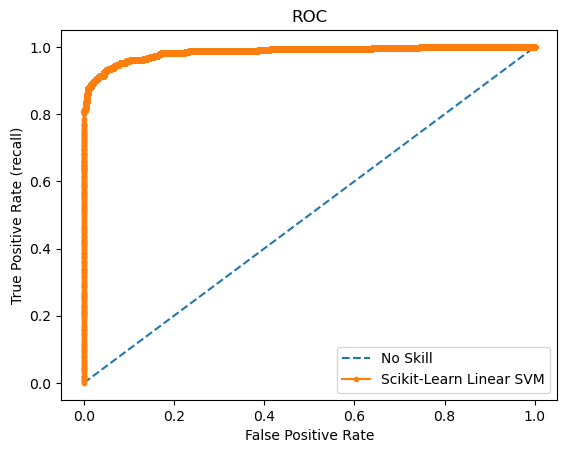

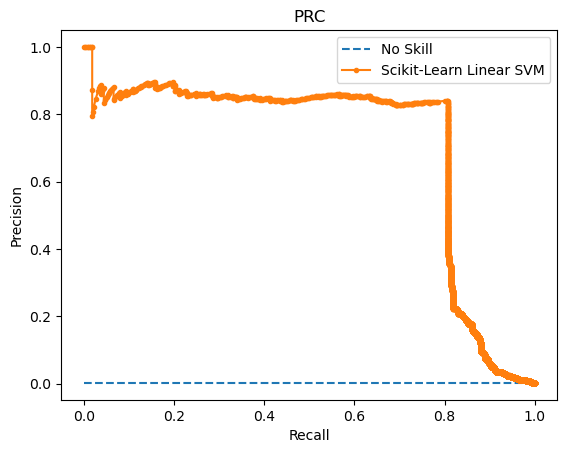

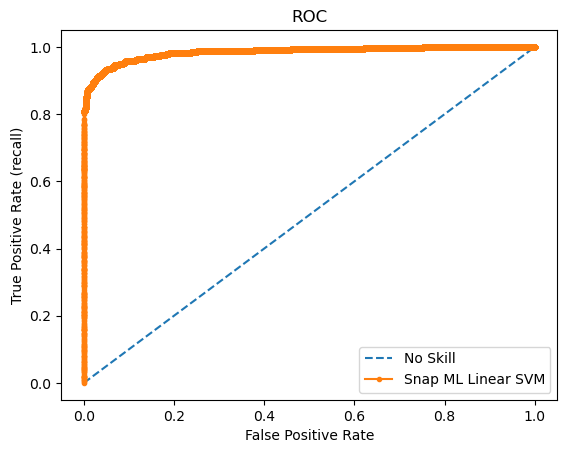

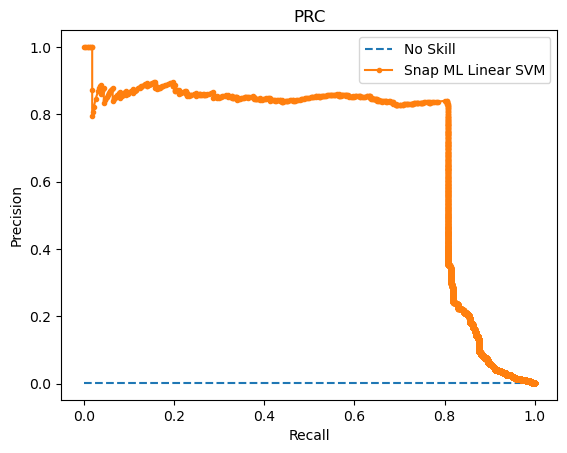

In [34]:
# plot roc curves
plot_roc_curve(y_test, naive_probs, sklearn_pred, 'Scikit-Learn Linear SVM')

# plot precision-recall curves
plot_pr_curve(y_test, sklearn_pred, 'Scikit-Learn Linear SVM')

# plot roc curves
plot_roc_curve(y_test, naive_probs, snapml_pred, 'Snap ML Linear SVM')

# plot precision-recall curves
plot_pr_curve(y_test, snapml_pred, 'Snap ML Linear SVM')

*We can observe that contrary to decision trees, the SVM model is accurate to predict the minority class, according to RP curve and AUC*.

# Authors' rights
Machine Learning with Python course by IBM on Coursera: https://www.coursera.org/learn/machine-learning-with-python/

Completed and modified by Mathilde Marie Duville as part of the IBM Artificial Intelligence Engineering Professional Certificate and corresponding IBM badges. Please, follow the subsequent links to confirm the accreditation:

https://www.coursera.org/account/accomplishments/professional-cert/KSLW773DAATP?utm_source=link&utm_medium=certificate&utm_content=cert_image&utm_campaign=sharing_cta&utm_product=prof

https://www.credly.com/users/mathilde-marie-duville/badges

-----------------------------------------------------------------------------------------------------------------------------------------

Author: Andreea Anghel

Other Contributors: Joseph Santarcangelo

Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2021-08-31  | 0.1  | AAN  |  Created Lab Content |


Copyright &copy; 2021 IBM Corporation. This notebook and its source code are released under the terms of the [MIT License](https://cognitiveclass.ai/mit-license/).